In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


# Test some fails

(-0.5, 461.5, 215.5, -0.5)

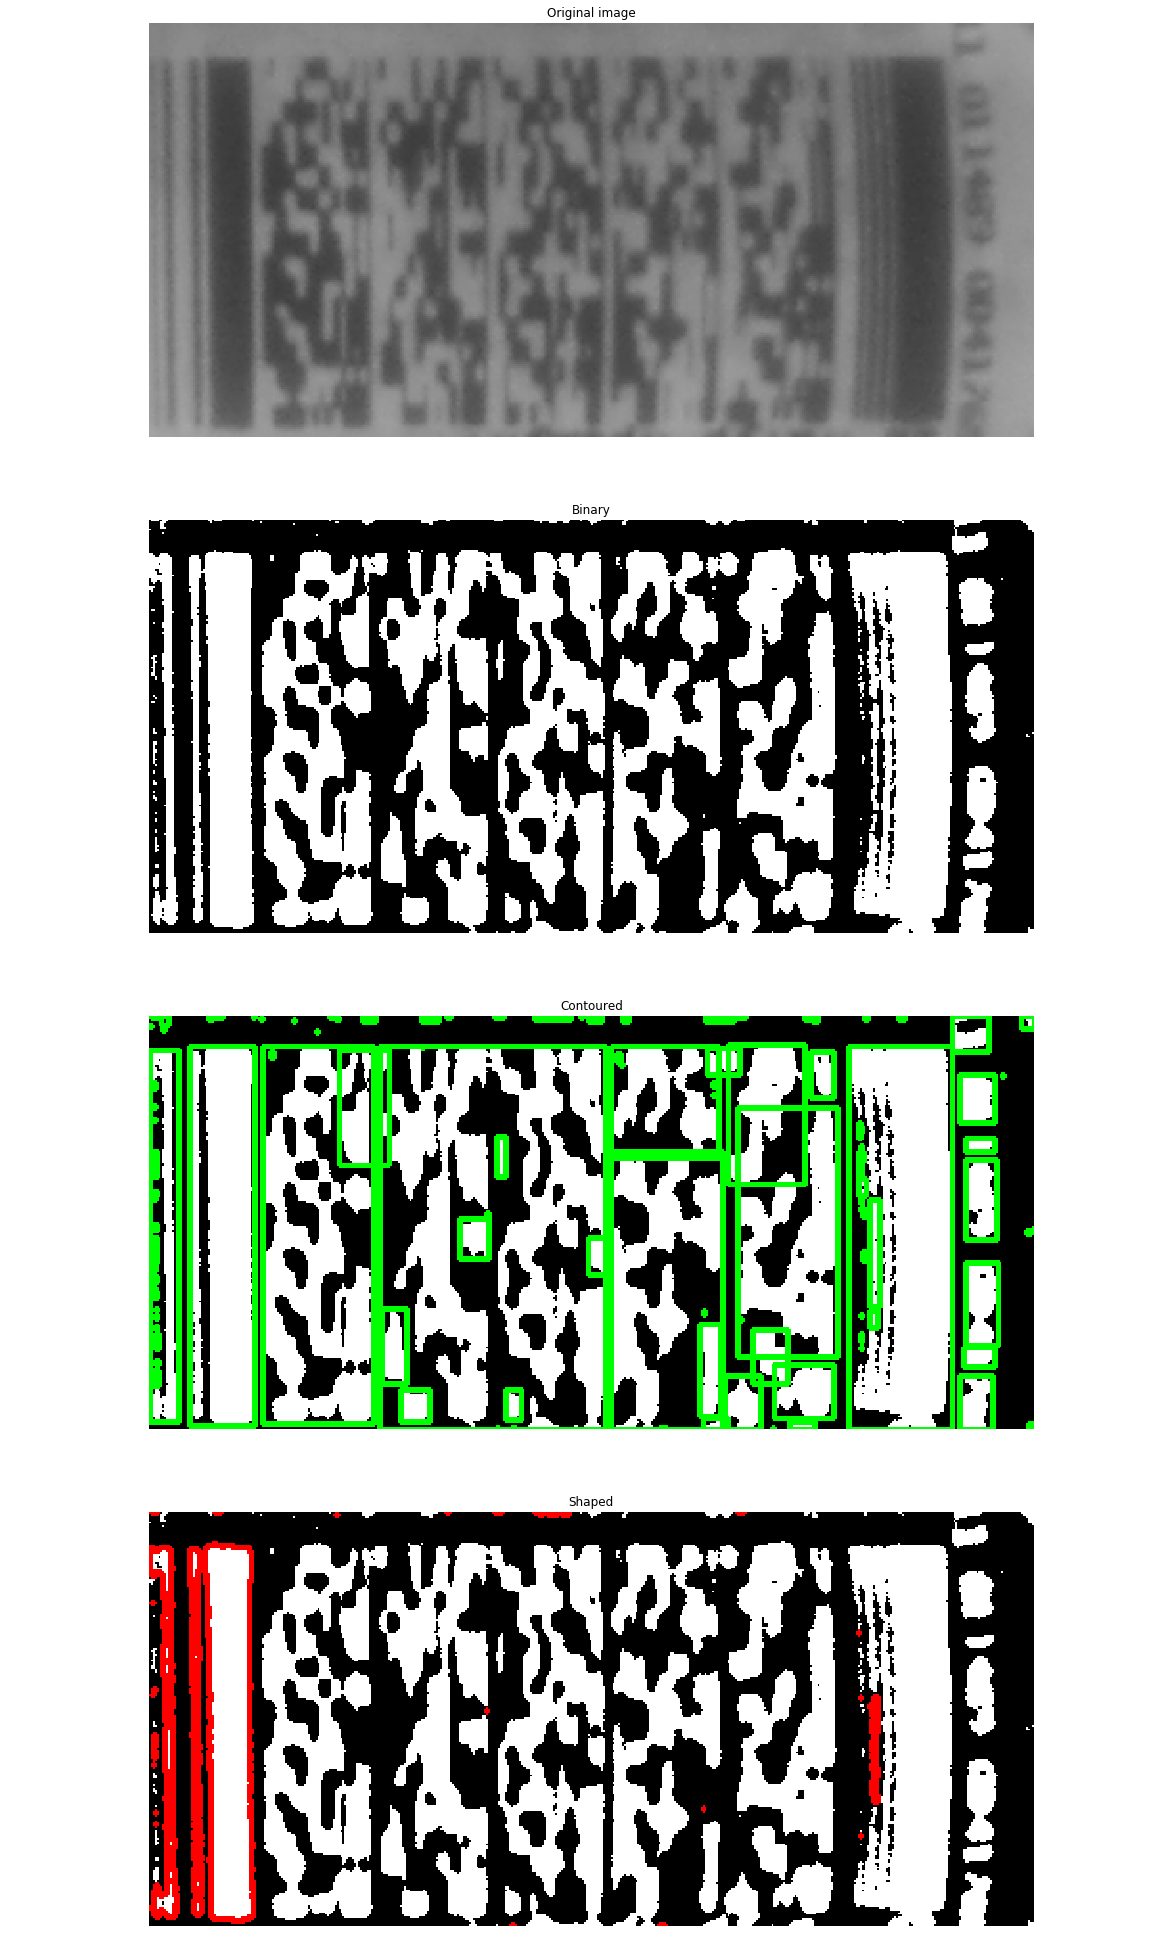

In [14]:
well = cv2.imread('test_data/maskedFinal720/_1521119599480_capture.png')[252:252+216, 523:523+462]
well = cv2.cvtColor(well, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(4, 1, figsize=(20, 35), sharex=True, sharey=True)
# ax = ax.ravel()

ax[0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
ax[0].set_title('Original image')
ax[0].axis('off')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clh = clahe.apply(well)
thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

ax[1].imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
ax[1].set_title('Binary')
ax[1].axis('off')

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
contours = np.dstack([thresh.copy()] * 3)
shapes = np.dstack([thresh.copy()] * 3)

# loop over the contours
for c in cnts:
    # draw contours
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)

    if (len(approx) == 2):
        rectangles_count += 1
        cv2.drawContours(shapes, [c], -1, (0, 0, 255), 2)

ax[2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contoured')
ax[2].axis('off')

ax[3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
ax[3].set_title('Shaped')
ax[3].axis('off')

## It's a little bit strange that some squares have only 2 nodes of the polygon. Well, let's use this

100%|██████████| 21/21 [00:02<00:00,  7.75it/s]


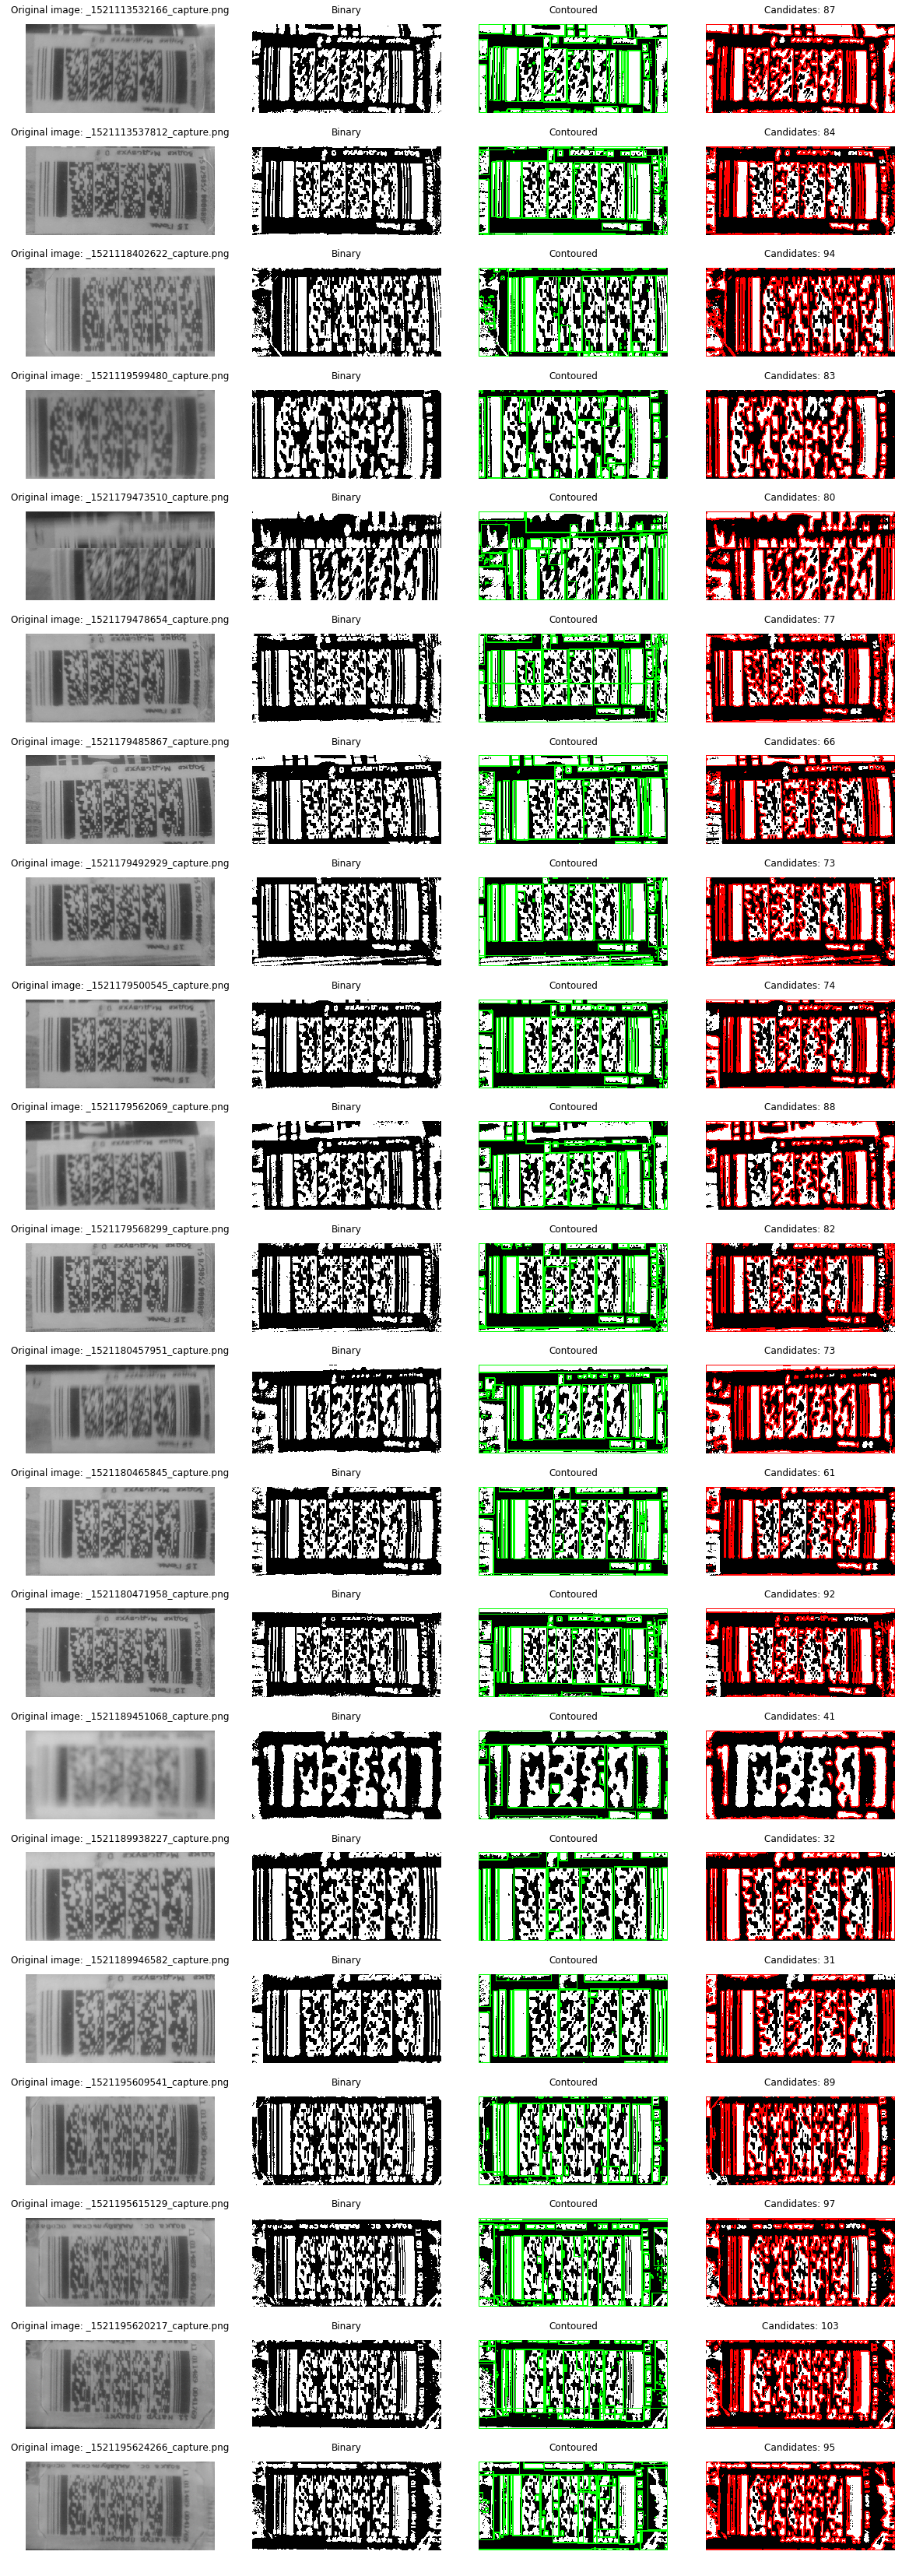

In [17]:
DIR = 'test_data/maskedFinal720'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig, ax = plt.subplots(filescount, 4, figsize=(20, 60), sharex=True, sharey=True)

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".PNG") or filename.endswith(".png")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))[252:252+216, 523:523+462]
    
    well = cv2.cvtColor(file_src, cv2.COLOR_BGR2GRAY)

    ax[current_file_index][0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][0].set_title('Original image: ' + filename)
    ax[current_file_index][0].axis('off')

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clh = clahe.apply(well)
    thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

    ax[current_file_index][1].imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][1].set_title('Binary')
    ax[current_file_index][1].axis('off')

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    contours = np.dstack([thresh.copy()] * 3)
    shapes = np.dstack([thresh.copy()] * 3)
    
    rectangles_count = 0

    # loop over the contours
    for c in cnts:
        # draw contours
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
               
        if (len(approx) > 1 and len(approx) < 7):
            rectangles_count += 1
            cv2.drawContours(shapes, [c], -1, (0, 0, 255), 2)

    ax[current_file_index][2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[current_file_index][2].set_title('Contoured')
    ax[current_file_index][2].axis('off')

    ax[current_file_index][3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
    ax[current_file_index][3].set_title('Candidates: ' + str(rectangles_count))
    ax[current_file_index][3].axis('off')
    
    current_file_index += 1

## The number of nodes at the polygon almost does not filter the outlines, so I will abandon this mechanism

### Try area filter

100%|██████████| 21/21 [00:02<00:00,  7.88it/s]


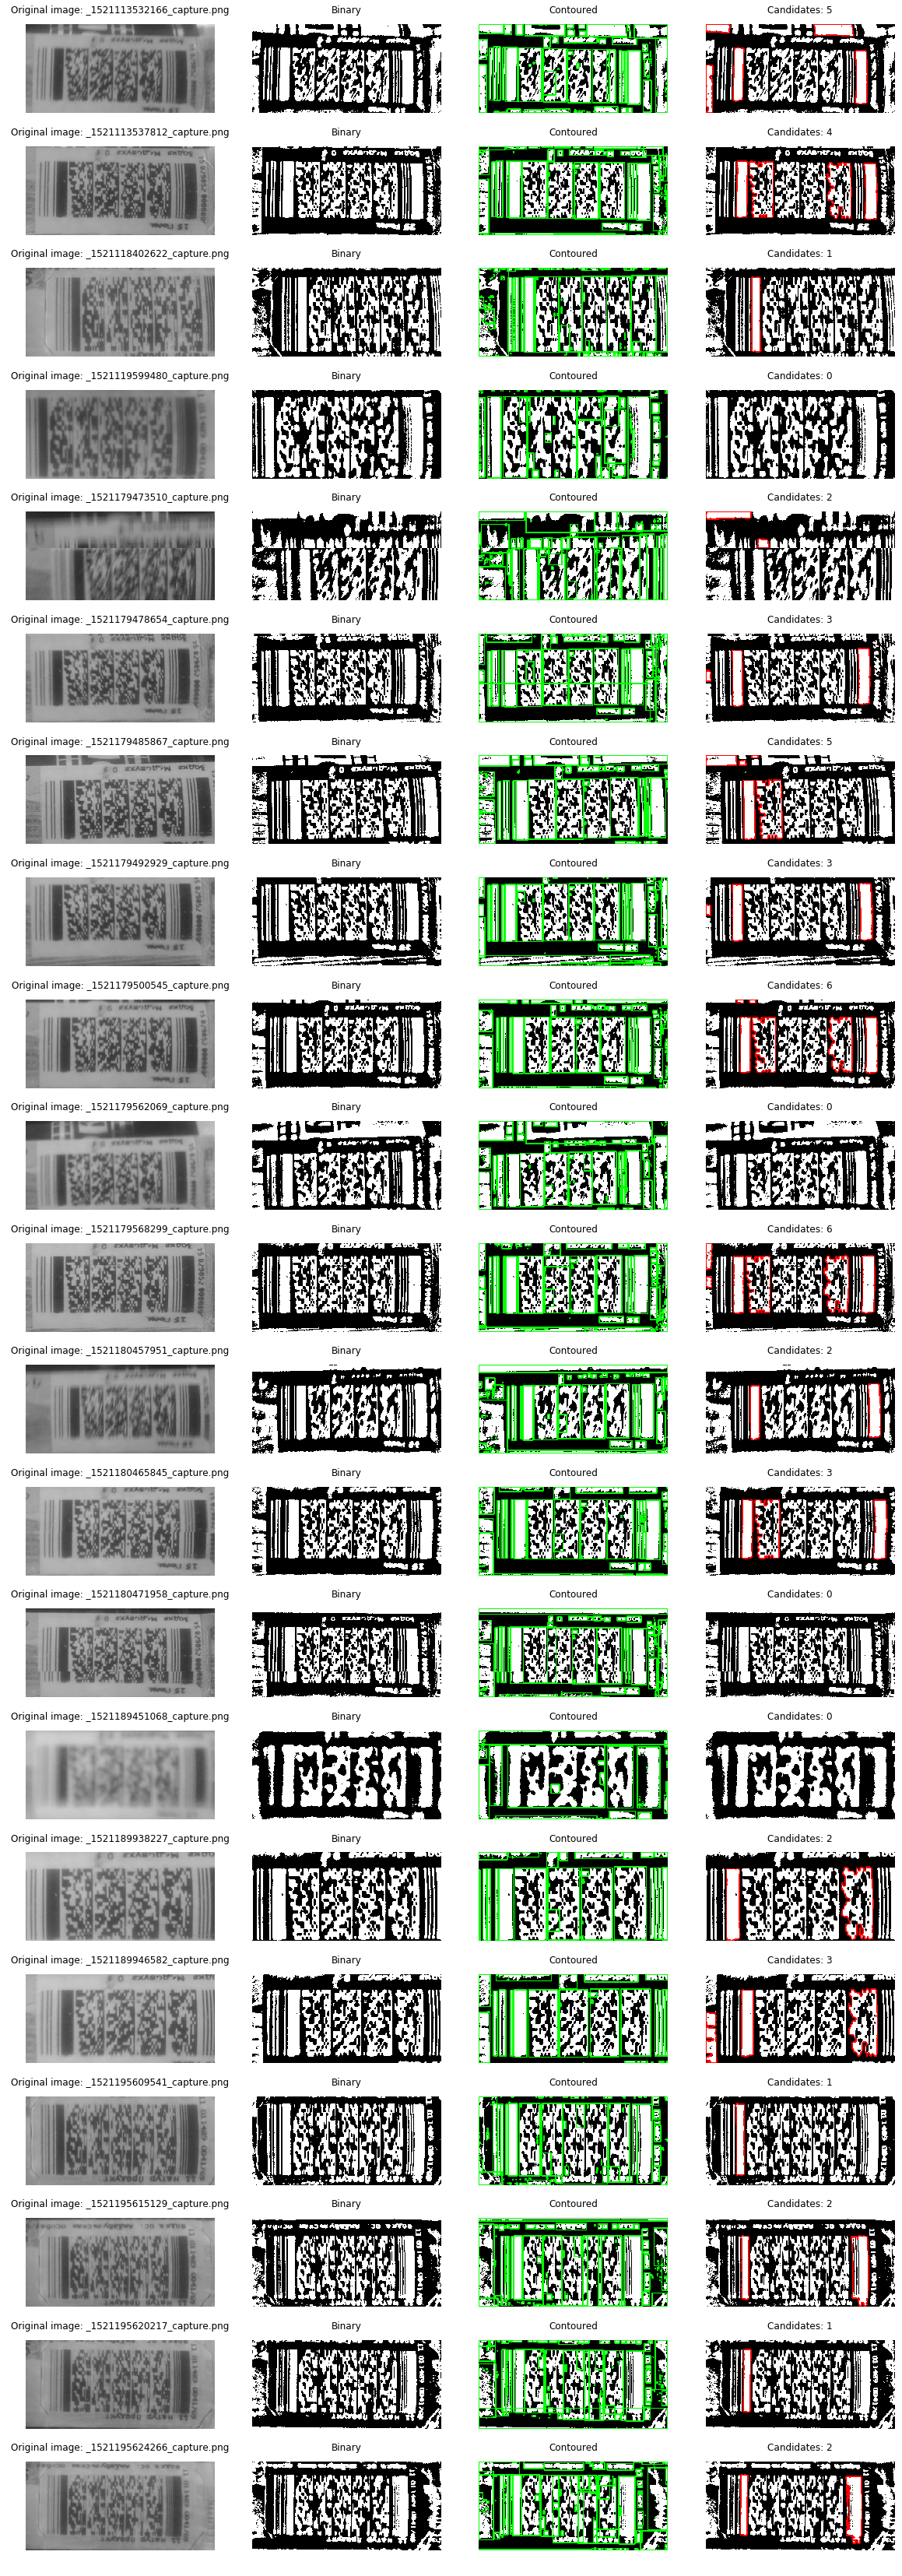

In [19]:
DIR = 'test_data/maskedFinal720'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig, ax = plt.subplots(filescount, 4, figsize=(20, 60), sharex=True, sharey=True)

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".PNG") or filename.endswith(".png")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))[252:252+216, 523:523+462]
    
    well = cv2.cvtColor(file_src, cv2.COLOR_BGR2GRAY)

    ax[current_file_index][0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][0].set_title('Original image: ' + filename)
    ax[current_file_index][0].axis('off')

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clh = clahe.apply(well)
    thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

    ax[current_file_index][1].imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][1].set_title('Binary')
    ax[current_file_index][1].axis('off')

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    contours = np.dstack([thresh.copy()] * 3)
    shapes = np.dstack([thresh.copy()] * 3)
    
    rectangles_count = 0

    # loop over the contours
    for c in cnts:
        # draw contours
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # peri = cv2.arcLength(c, True)
        # approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        area = cv2.contourArea(c)
        
        if (area > 0):
            if (w*h / area > .7 and w*h / area < 1.3):
                rectangles_count += 1
                cv2.drawContours(shapes, [c], -1, (0, 0, 255), 2)

    ax[current_file_index][2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[current_file_index][2].set_title('Contoured')
    ax[current_file_index][2].axis('off')

    ax[current_file_index][3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
    ax[current_file_index][3].set_title('Candidates: ' + str(rectangles_count))
    ax[current_file_index][3].axis('off')
    
    current_file_index += 1

## Good result.